In [ ]:
import pyspark
from pyspark.sql import SparkSession
import functions_pyspark as func
from pyspark.sql.types import *
from pyspark.sql.functions import *
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
app = func.leer_archivo("/Users/franca/Documents/GitHub/ETL-con-pyspark/input_data/googleplaystore.csv") 
print(app)

24/10/25 12:44:45 WARN Utils: Your hostname, MacBook-Pro-de-Nahuel.local resolves to a loopback address: 127.0.0.1; using 192.168.18.36 instead (on interface en7)
24/10/25 12:44:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/25 12:44:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|    10,000+|Free|    0|      Everyone|        Art & Design|   January 7, 2018|             1.0.0|4.0.3 and up|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|   500,000+|Free|    0|      Everyone|Art & Design;Pret...|  January 15, 2018|             2.0.0|4.0.3 and up|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510|8.7M| 5,000,000+|Free|    0|      Everyone|        Art & Design|    August 1, 2018|             1.2.4|4.0.3 

In [ ]:
#imprimir el schema

app.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



In [ ]:
explorar = func.exploracion_datos(app)

_____________ INFORMACIÓN GENERAL DEL CSV ____________

El número de filas que tenemos es de 10841.
El número de columnas es de 13

____________ DUPLICADOS EN CADA COLUMNA ______________ 

Las columnas con duplicados son: App, Category, Rating, Reviews, Size, Installs, Type, Price, Content Rating, Genres, Last Updated, Current Ver, Android Ver

____________ NULOS EN CADA COLUMNA ______________ 

Procesando columna: App
Tipo de dato de App: string
Nulos en App: 0, No nulos en App: 10841
Procesando columna: Category
Tipo de dato de Category: string
Nulos en Category: 0, No nulos en Category: 10841
Procesando columna: Rating
Tipo de dato de Rating: string
Nulos en Rating: 0, No nulos en Rating: 10841
Procesando columna: Reviews
Tipo de dato de Reviews: string
Nulos en Reviews: 0, No nulos en Reviews: 10841
Procesando columna: Size
Tipo de dato de Size: string
Nulos en Size: 0, No nulos en Size: 10841
Procesando columna: Installs
Tipo de dato de Installs: string
Nulos en Installs: 0, No nu

In [ ]:
# Definir los reemplazos

print('_____________ CORREGIR LOS REGISTROS EN LA COLUMNA RATING Y CAMBIAR EL DTYPE A DOUBLE ____________\n')


app = app.withColumn(
    'Rating', 
    when(col('Rating') == ' navigation', None)  # Reemplazar 'navigation' con None (equivalente a NaN)
    .when(col('Rating') == 'Body', None)       # Reemplazar 'Body' con None
    .when(col('Rating') == '19', '1.9')        # Reemplazar '19' con '1.9'
    .when(col('Rating') == 'NaN', None)        # Reemplazar 'NaN' con None
    .otherwise(col('Rating'))                  # Mantener los demás valores iguales
)

_____________ CORREGIR LOS REGISTROS EN LA COLUMNA RATING Y CAMBIAR EL DTYPE A DOUBLE ____________



In [ ]:
print('_____________ CORREGIR LOS REGISTROS EN LA COLUMNA REVIEWS Y CAMBIAR EL DTYPE A DOUBLE ____________\n')

# convertir a número y manejar errores
app = app.withColumn(
    'Reviews',
    when(col('Reviews').cast('double').isNotNull(), col('Reviews').cast('double'))
    .otherwise(None)  # Reemplaza valores no numéricos con None
)

# Eliminar filas con valores None en 'Reviews'
app = app.filter(col('Reviews').isNotNull())

#mostrar el DF limpio
app.show()

_____________ CORREGIR LOS REGISTROS EN LA COLUMNA REVIEWS Y CAMBIAR EL DTYPE A DOUBLE ____________

+--------------------+--------------+------+--------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+
|                 App|      Category|Rating| Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver| Android Ver|
+--------------------+--------------+------+--------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|   159.0| 19M|    10,000+|Free|    0|      Everyone|        Art & Design|   January 7, 2018|             1.0.0|4.0.3 and up|
| Coloring book moana|ART_AND_DESIGN|   3.9|   967.0| 14M|   500,000+|Free|    0|      Everyone|Art & Design;Pret...|  January 15, 2018|             2.0.0|4.0.3 and up|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7| 87510.0|8

In [ ]:
print('_____________ CORREGIR LOS REGISTROS EN LA COLUMNA SIZE Y CAMBIAR EL DTYPE A LONG ____________\n')


app = app.withColumn('Size', 
    when(col('Size').endswith('M'), 
         (trim(regexp_replace(col('Size'), 'M', '')).cast('double') * 1000000).cast('long'))  # Convertir M a bytes
    .when(col('Size').endswith('K'), 
         (trim(regexp_replace(col('Size'), 'K', '')).cast('double') * 1000).cast('long'))  # Convertir K a bytes
    .when(col('Size').endswith('k'), 
         (trim(regexp_replace(col('Size'), 'k', '')).cast('double') * 1000).cast("long"))  # Convertir k a bytes
    .otherwise(None)  # Para manejar otros casos o datos no válidos
)

# Mostrar el DataFrame para verificar el cambio
app.select('Size').show()

_____________ CORREGIR LOS REGISTROS EN LA COLUMNA SIZE Y CAMBIAR EL DTYPE A LONG ____________

+--------+
|    Size|
+--------+
|19000000|
|14000000|
| 8700000|
|25000000|
| 2800000|
| 5600000|
|19000000|
|29000000|
|33000000|
| 3100000|
|28000000|
|12000000|
|20000000|
|21000000|
|37000000|
| 2700000|
| 5500000|
|17000000|
|39000000|
|31000000|
+--------+
only showing top 20 rows



In [ ]:
print('_____________ CORREGIR LOS REGISTROS EN LA COLUMNA INSTALLS Y CAMBIAR EL DTYPE A LONG ____________\n')

app = app.withColumn('Installs', 
                     when(col('Installs') == 'Free', None)  # Reemplazar "Free" con None
                     .otherwise(
                         regexp_replace(regexp_replace(col('Installs'), ',', ''), r'\+', '')  # Quitar comas y signo "+"
                     ).cast('int'))  # Convertir a entero

# Mostrar los resultados para verificar
app.select('Installs').show()

_____________ CORREGIR LOS REGISTROS EN LA COLUMNA INSTALLS Y CAMBIAR EL DTYPE A LONG ____________

+--------+
|Installs|
+--------+
|   10000|
|  500000|
| 5000000|
|50000000|
|  100000|
|   50000|
|   50000|
| 1000000|
| 1000000|
|   10000|
| 1000000|
| 1000000|
|10000000|
|  100000|
|  100000|
|    5000|
|  500000|
|   10000|
| 5000000|
|10000000|
+--------+
only showing top 20 rows



In [ ]:
print('_____________ CORREGIR LOS REGISTROS EN LA COLUMNA TYPE  ____________\n')

app = app.fillna({'Type': 'Unknown'})

# Mostrar el DataFrame para verificar el cambio
app.select('Type').show()

_____________ CORREGIR LOS REGISTROS EN LA COLUMNA TYPE  ____________

+----+
|Type|
+----+
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
|Free|
+----+
only showing top 20 rows



In [ ]:
print('_____________ CORREGIR LOS REGISTROS EN LA COLUMNA PRICE Y CAMBIAR EL DTYPE A DOUBLE ____________\n')

app = app.withColumn('Price', 
                     regexp_replace(col('Price'), '\\$', '')  # Quitar el signo $
                     )

# Reemplazar registros que contengan 'M' o sean 'Varies with device' y 'Everyone' con None
app = app.withColumn('Price', 
                     when(col('Price').contains('M'), None)  # Reemplazar registros con 'M' con None
                     .when(col('Price') == 'Varies with device', None)  # Reemplazar 'Varies with device' con None
                     .when(col('Price') == 'Everyone', None)  # Reemplazar 'Everyone' con None
                     .otherwise(col('Price')))

# Convertir la columna 'Price' a tipo numérico (double)
app = app.withColumn('Price', col('Price').cast('double'))

# Mostrar el DataFrame para verificar los cambios
app.select('Price').show()

_____________ CORREGIR LOS REGISTROS EN LA COLUMNA PRICE Y CAMBIAR EL DTYPE A DOUBLE ____________

+-----+
|Price|
+-----+
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
+-----+
only showing top 20 rows



In [ ]:
app.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: double (nullable = true)
 |-- Size: long (nullable = true)
 |-- Installs: integer (nullable = true)
 |-- Type: string (nullable = false)
 |-- Price: double (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



In [ ]:
#describir los datos estadisticos

app['Rating', 'Reviews', 'Size', 'Installs', 'Price'].describe().toPandas()

24/10/25 12:44:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,Rating,Reviews,Size,Installs,Price
0,count,9364,10838,9144,10838,10838
1,mean,4.191734301580527,444225.1924709356,2.151833578521435E7,1.546663900046134E7,1.0275576674663114
2,stddev,0.5152693809765408,2928025.838407947,2.2589322733755987E7,8.50370342845836E7,15.951169076625343
3,min,1.0,0.0,8500,0,0.0
4,max,5.0,7.8158306E7,100000000,1000000000,400.0


_____________ ANÁLISIS DE LA DISTRIBUCIÓN DE RATINGS____________

_____________ Histograma para ver la distribución de valores específicos ____________



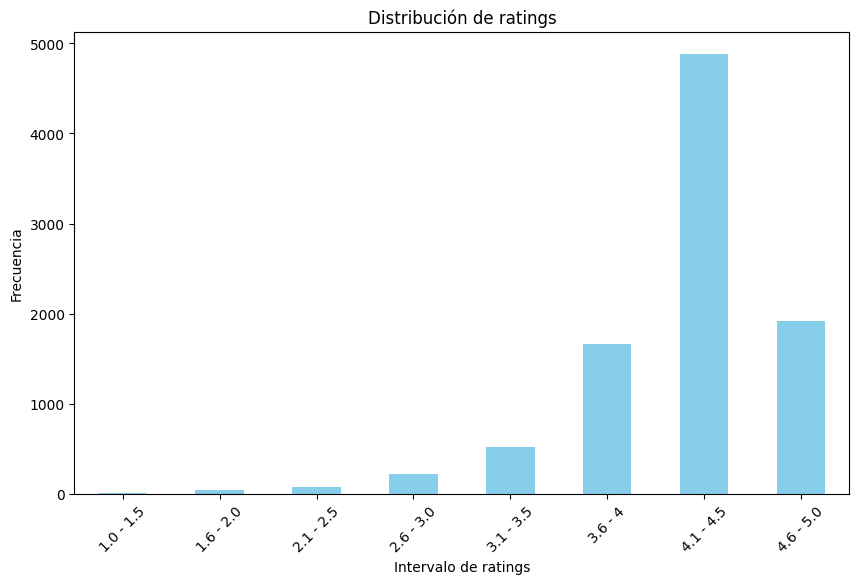

In [ ]:
print('_____________ ANÁLISIS DE LA DISTRIBUCIÓN DE RATINGS____________\n')
print('_____________ Histograma para ver la distribución de valores específicos ____________\n')

#seleccionar la columna a graficar y convertir a pandas

df_ratings = app.select('Rating').toPandas()

#convertir rating a numerico, forzando errores a NaN y eliminarlos

df_ratings['Rating'] = pd.to_numeric(df_ratings['Rating'], errors = 'coerce')
df_ratings = df_ratings.dropna(subset=['Rating'])

#definir los intervalos personalizados y etiquetas

bins = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
labels = ['1.0 - 1.5', '1.6 - 2.0', '2.1 - 2.5', '2.6 - 3.0', '3.1 - 3.5', '3.6 - 4', '4.1 - 4.5', '4.6 - 5.0' ]

# Agruparlos en los intervalos definidos 

df_ratings['RatingGroup'] = pd.cut(df_ratings['Rating'], bins = bins, labels = labels)
rating_counts = df_ratings['RatingGroup'].value_counts().sort_index()

#Configurar el tamaño de los gráficos

plt.figure(figsize=[10, 6])

#Histograma de ratingss

rating_counts.plot(kind = 'bar', color = 'skyblue')
plt.title('Distribución de ratings')
plt.xlabel('Intervalo de ratings')
plt.ylabel('Frecuencia')
plt.xticks(rotation = 45)
plt.show()

_____________ Tendencia de concentración de los datos ____________



<ipython-input-14-fa96fb11069c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = rating_counts.index, y = rating_counts.values, palette = 'Blues_d')


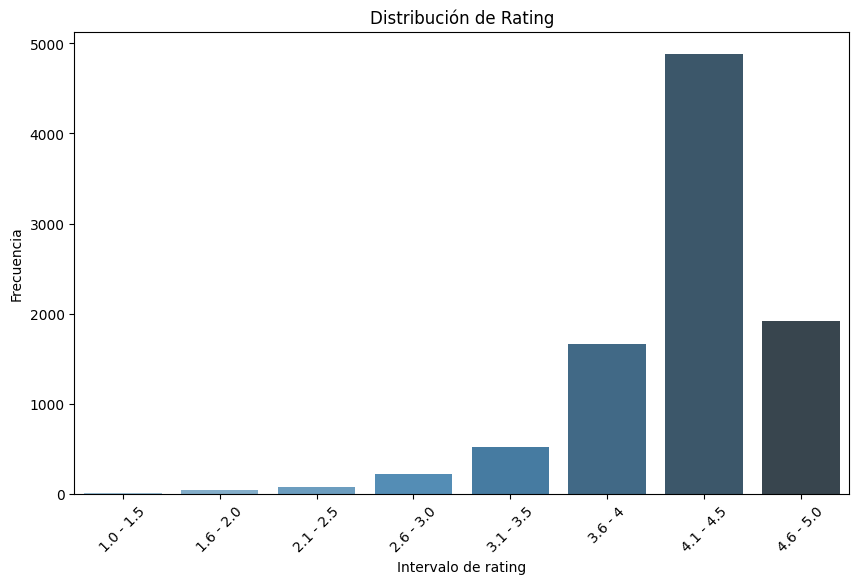

In [ ]:
print('_____________ Tendencia de concentración de los datos ____________\n')

plt.figure(figsize = (10,6))
sns.barplot(x = rating_counts.index, y = rating_counts.values, palette = 'Blues_d')
plt.title('Distribución de Rating')
plt.xlabel('Intervalo de rating')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

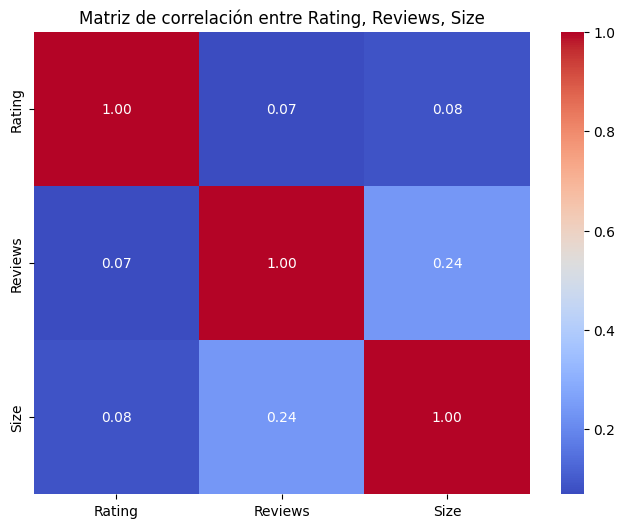

In [ ]:
#Seleccionar columnas relevantes
#covnertir a pandas para poder graficar

app_grafico = app.select('Rating', 'Reviews', 'Size').toPandas()


#Calcular matriz de correlación

matriz_correlacion = app_grafico[['Rating', 'Reviews','Size']].corr()

#Visualizar la matriz de correlación

plt.figure(figsize=(8,6))
sns.heatmap(matriz_correlacion, annot = True, cmap= 'coolwarm', fmt = ".2f")
plt.title("Matriz de correlación entre Rating, Reviews, Size")
plt.show()